In [1]:
import numpy
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("dataset/train_data.csv")

In [3]:
df.columns

Index(['BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'POSTCODE', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'Borough', 'Latitude',
       'Longitude', 'Community Board', 'Council District', 'Census Tract',
       'BIN', 'NTA', 'New Georeferenced Column'],
      dtype='object')

In [4]:
df.dtypes

BBLE                         object
BORO                          int64
BLOCK                         int64
LOT                           int64
EASEMENT                     object
OWNER                        object
BLDGCL                       object
TAXCLASS                     object
LTFRONT                       int64
LTDEPTH                       int64
EXT                          object
STORIES                     float64
FULLVAL                       int64
AVLAND                        int64
AVTOT                         int64
EXLAND                        int64
EXTOT                         int64
EXCD1                       float64
STADDR                       object
POSTCODE                    float64
EXMPTCL                      object
BLDFRONT                      int64
BLDDEPTH                      int64
AVLAND2                     float64
AVTOT2                      float64
EXLAND2                     float64
EXTOT2                      float64
EXCD2                       

In [5]:
def df_info(df):
    #print(df.info())
    return df

In [6]:
def select_columns(df, columns=[]):
    """
    Selects columns from `columns`
    """
    return df.loc[:,columns]

In [7]:
def encode_easement(df):
    df.EASEMENT = df.EASEMENT.apply(lambda x: int(len(str(x)) == 1))
    return df

In [8]:
def fix_stories(df):
    df.STORIES.fillna(0, inplace=True)
    return df

In [9]:
df["NTA_VAL"] = df.NTA.map(df.groupby("NTA").mean().FULLVAL)
df["BORO_VAL"] = df.BORO.map(df.groupby("BORO").mean().FULLVAL)
df["BLOCK_VAL"] = df.BLOCK.map(df.groupby("BLOCK").mean().FULLVAL)

In [10]:
result = df.pipe(df_info) \
  .pipe(select_columns, columns=
          [
           "BORO",
           "EASEMENT",
           "TAXCLASS",
           "LTFRONT",
           "LTDEPTH",
           "AVTOT",
           "EXLAND",
           "EXTOT",
           "STORIES",
           "FULLVAL", # Y
           #"NTA",
           #"NTA_VAL",
           "BORO_VAL",
           "BLOCK_VAL"
          ]) \
  .pipe(fix_stories) \
  .pipe(encode_easement)

In [11]:
result.isna().sum(axis=0)

BORO         0
EASEMENT     0
TAXCLASS     0
LTFRONT      0
LTDEPTH      0
AVTOT        0
EXLAND       0
EXTOT        0
STORIES      0
FULLVAL      0
BORO_VAL     0
BLOCK_VAL    0
dtype: int64

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [13]:
pipe = Pipeline([
        ("encode_onehot", 
            ColumnTransformer(
                [
                    ("onehot", OneHotEncoder(), ["TAXCLASS"])
                ],
                remainder='passthrough'
            )
        ),     
])

In [14]:
pipe.fit(result)

Pipeline(steps=[('encode_onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['TAXCLASS'])]))])

In [15]:
pipe.fit(result)
X = pipe.transform(result)

In [16]:
y = df.FULLVAL

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

In [18]:
regressor = DecisionTreeRegressor(max_depth=5)
r = cross_val_score(regressor, X, y, cv=10)
r

array([0.91842921, 0.99241349, 0.99122124, 0.98760344, 0.975597  ,
       0.88563405, 0.99054426, 0.98593064, 0.84948731, 0.99029519])

In [19]:
np.mean(r)

0.9567155819618336

In [20]:
regressor.fit(X, y)

DecisionTreeRegressor(max_depth=5)

In [21]:
regressor.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.77965626e-04, 0.00000000e+00,
       0.00000000e+00, 1.52662008e-04, 7.35103120e-01, 4.02273012e-05,
       8.23965271e-04, 0.00000000e+00, 2.58286876e-01, 0.00000000e+00,
       5.21518346e-03])

In [22]:
from pycaret.regression import *

In [30]:
smol = result[result.FULLVAL < 1e6]

In [31]:
s = setup(smol, target = 'FULLVAL')

,Description,Value
0,session_id,1710
1,Target,FULLVAL
2,Original Data,"(9931, 12)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6951, 24)"


In [32]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,25550.4842,3024210231.8665,54776.4386,0.9396,0.4075,0.0779,0.1090
rf,Random Forest Regressor,26177.5247,3039022234.9292,54847.6350,0.9393,0.4615,0.0859,0.1400
lightgbm,Light Gradient Boosting Machine,31486.6396,3125331909.7799,55679.4143,0.9376,1.4609,0.1876,0.0200
gbr,Gradient Boosting Regressor,41689.3304,4289765850.5270,65303.7043,0.9143,1.5986,0.5256,0.0870
dt,Decision Tree Regressor,32067.1944,4966676623.6972,70394.9046,0.9009,0.2638,0.0878,0.0110
ridge,Ridge Regression,70200.7107,10219791578.7626,100989.5643,0.7959,1.6749,0.7416,0.0070
lasso,Lasso Regression,70244.4911,10228126762.2877,101033.2658,0.7958,1.6729,0.7247,0.0160
llar,Lasso Least Angle Regression,70148.7971,10228061724.5808,101032.8044,0.7958,1.6729,0.7262,0.0070
knn,K Neighbors Regressor,66224.7236,15805451019.1880,125423.2086,0.6845,1.6828,0.9828,0.0110
ada,AdaBoost Regressor,103998.2084,15972394083.8654,126182.0707,0.6813,1.9475,1.8260,0.0420


In [33]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

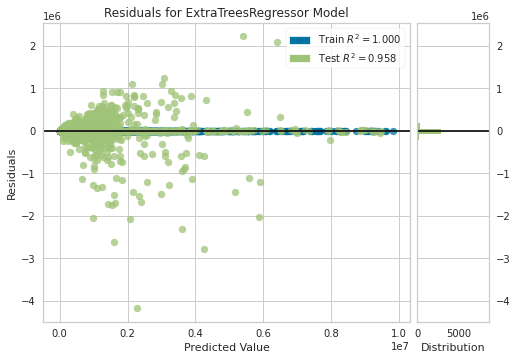

In [37]:
plot_model(best, plot = 'residuals')